### import the libraries

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### utility functions (no change is needed in this section)

In [13]:
def show_images(*images, titles=None):
    """
    Displays multiple images using matplotlib.

    Args:
        *images: Variable length image list to display.
        titles (list, optional): Titles for each subplot. Defaults to None.

    Returns:
        None
    """
    num_images = len(images)
    plt.figure(figsize=(15, 12))

    for i, image in enumerate(images):
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if titles:
            plt.title(titles[i])
        plt.axis('off')

    plt.show()

In [14]:
def draw_corners_on_image(image, corners, neighborhood_size):
    """
    Draws circles on the original image at detected corner locations.

    Args:
        image (numpy.ndarray): Original image.
        corners (numpy.ndarray): Binary image with corner detections.
        neighborhood_size (int): Size of the neighborhood used for corner detection.

    Returns:
        numpy.ndarray: Image with corners marked.
    """
    height, width = image.shape[:2]
    offset = neighborhood_size // 2

    for y in range(offset, height - offset):
        for x in range(offset, width - offset):
            if corners[y, x] == 255:
                cv2.circle(image, (x, y), 5, (255, 0, 0), -1)

    return image

In [15]:
def draw_matches(img1, img2, kp1, kp2, matches):
    """
    Draws matches between keypoints of two images.

    Args:
        img1 (numpy.ndarray): First image.
        img2 (numpy.ndarray): Second image.
        kp1 (list): Keypoints in the first image.
        kp2 (list): Keypoints in the second image.
        matches (list): List of matched keypoints.

    Returns:
        numpy.ndarray: Image with matches drawn.
    """
    return cv2.drawMatches(
        img1, kp1,
        img2, kp2,
        matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

### image stitching

In [34]:
def sift_feature_matching(img1, img2):
    """
    Performs SIFT feature detection and matching between two images.

    Args:
        img1 (numpy.ndarray): First grayscale image.
        img2 (numpy.ndarray): Second grayscale image.

    Returns:
        tuple: Source points, destination points, and image with matches drawn.
    """
    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # BFMatcher with default params
    bf = cv2.BFMatcher(crossCheck=True)
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # Extract source and destination points
    src_pts = []
    dst_pts = []

    for match in matches:
        src_pts.append(kp1[match.queryIdx].pt)  # (x, y) in img1
        dst_pts.append(kp2[match.trainIdx].pt)  # (x, y) in img2
    
    matched_img = draw_matches(img1, img2, kp1, kp2, matches)

    return np.array(src_pts, dtype=np.float32), np.array(dst_pts, dtype=np.float32), matched_img

In [51]:
def ransac_homography(src_pts, dst_pts, num_iterations=2000, threshold=4):
    """
    Computes the best homography matrix using RANSAC.

    Args:
        src_pts (numpy.ndarray): Source points from the first image.
        dst_pts (numpy.ndarray): Destination points from the second image.
        num_iterations (int): Number of RANSAC iterations. Default is 2000.
        threshold (float): Distance threshold to determine inliers. Default is 4.

    Returns:
        numpy.ndarray: Homography matrix.
    """
    best_H = None
    max_inliers = 0
    num_points = len(src_pts)

    for _ in range(num_iterations):
        # Get 4 distinct random indices
        random_indices = np.random.choice(range(num_points), 4, replace=False)

        # Find homography matrix for these 4 points
        mat = cv2.getPerspectiveTransform(src_pts[random_indices], dst_pts[random_indices])

        # Find transform point for all points with the mat
        new_dst_pts = cv2.perspectiveTransform(src_pts.reshape(-1, 1, 2), mat)

        # Find number of inliers
        num_inliers = 0
        for i in range(num_points):
            dst = np.array(dst_pts[i])
            new_dst = new_dst_pts[i, 0, :]
            dist = np.sqrt((dst[0] - new_dst[0])**2 +  (dst[1] - new_dst[1])**2)
            if dist <= threshold:
                num_inliers += 1
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_H = mat
            
    return best_H

In [106]:
def stitch_images(img1, img2, H):
    """
    Stitches two images together using a homography matrix.

    Args:
        img1 (numpy.ndarray): First image.
        img2 (numpy.ndarray): Second image.
        H (numpy.ndarray): Homography matrix.

    Returns:
        numpy.ndarray: Stitched image.
    """
    height, width = img2.shape[:2]

    # Warp img1 to align with img2 using the homography matrix
    warped_img1 = cv2.warpPerspective(img1, H, (900, 480))
    warped_img1[:height, :width] = img2
    

    return warped_img1

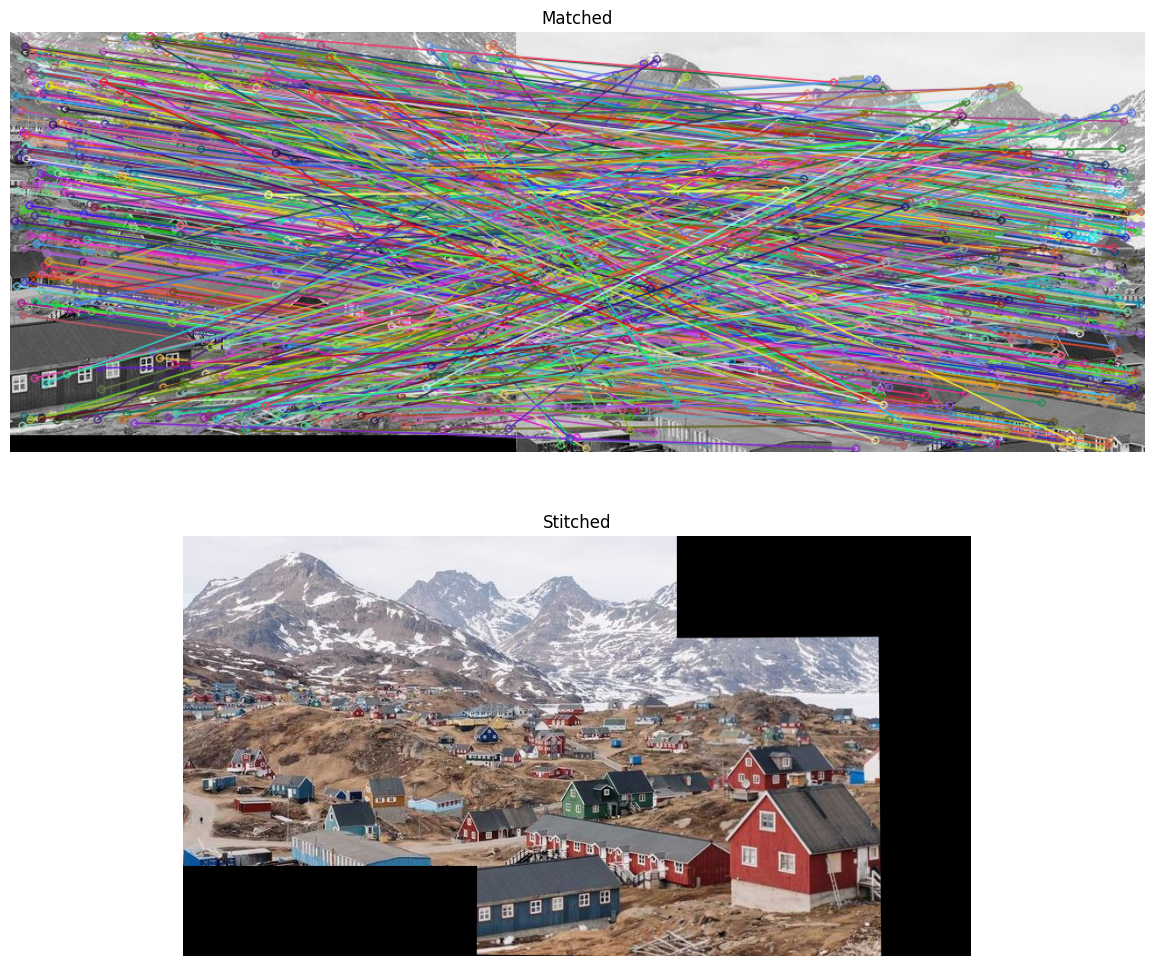

In [107]:
# Load images

left_path = 'Q2-imgs/left.jpg'
right_path = 'Q2-imgs/right.jpg'

img1 = cv2.imread(right_path)
img2 = cv2.imread(left_path)

# Convert images to grayscale

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Extract features and matching points

src_pts, dst_pts, matched_img = sift_feature_matching(img1_gray, img2_gray)
# Find the best homography using RANSAC

homography_matrix = ransac_homography(src_pts, dst_pts)

# Stitch images together

warped_img1 = stitch_images(img1, img2, homography_matrix)

# Display the matched keypoints and the final stitched image

show_images(matched_img, warped_img1, titles=["Matched", "Stitched"])